# Importing the libraries we will need


In [462]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import scale
from sklearn.decomposition import IncrementalPCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, recall_score, confusion_matrix
%matplotlib inline

# if you have problems running the code please contact us


# Important

The datasets and the images used in this notebook can be found here: [dropbox link](https://www.dropbox.com/sh/p51tigorc1qu9h3/AAAA6kYDGdmLUPkwrEa0Ng8ha?dl=0).

The ipynb file must be in the same folder as the folder "data" (from dropbox).

And please run this notebook with Python 3 kernel.

# *Familiarization task*

For the familiarization task we are going to read our datasets (by using the pandas library) and examine them.

To do so, we firstly define the path that leads to our datasets.

In [463]:
attack_data_path = os.path.join('data', 'SWaT_Dataset_Attack_v0.csv')
normal_data_path = os.path.join('data', 'SWaT_Dataset_Normal_v0.csv')

print("Path of the attack dataset: %s" %attack_data_path)
print("Path of the normal dataset: %s" %normal_data_path)


Path of the attack dataset: data/SWaT_Dataset_Attack_v0.csv
Path of the normal dataset: data/SWaT_Dataset_Normal_v0.csv


# Read the data and initial pre-processing

The "read_from_file()" function below, converts the csv into a pandas dataframe.
The initial pre-processing that we do is:
* skip the first line (it is empty)
* skip blank lines 
* convertion of the labels {Normal, Attack} to {0, 1} (0 = Normal, 1 = Attack). In this step we realized that some "Attack" labels were written as "A ttack" so we labeled them as 1 too.

This function returns two pandas dataframes, one for the attack dataset and another one for the normal dataset.

In [464]:
def read_from_file():
    print("Reading Attack and Normal dataset from file.")
    converters = {'Normal/Attack': lambda x: 1 if (x == "A ttack" or x == "Attack") else 0}

    attack_data = pd.read_csv(attack_data_path, skip_blank_lines=True, skiprows=1, converters=converters)
    normal_data = pd.read_csv(normal_data_path, skip_blank_lines=True, skiprows=1, converters=converters)
    print("\t\tDone.")
    return attack_data, normal_data

Now we are able to read our datasets.

In [465]:
attack_data, normal_data = read_from_file()

Reading Attack and Normal dataset from file.
		Done.


# Examination of our data
Let's find out how many columns do our csv files have and if both datasets contain the same columns.

In [466]:
# Remove the whitespaces from the column names
strip = lambda container: map(lambda element: element.strip(), container)
attack_data.columns = strip(attack_data.columns.tolist())
normal_data.columns = strip(normal_data.columns.tolist())

print (len(list(normal_data)))
print (len(list(attack_data)))
print(list(attack_data) == list(normal_data))


53
53
True


Thus, we have the same 53 columns in both datasets.

Let's find out the names of those columns.

In [467]:
print (list(attack_data))

['Timestamp', 'FIT101', 'LIT101', 'MV101', 'P101', 'P102', 'AIT201', 'AIT202', 'AIT203', 'FIT201', 'MV201', 'P201', 'P202', 'P203', 'P204', 'P205', 'P206', 'DPIT301', 'FIT301', 'LIT301', 'MV301', 'MV302', 'MV303', 'MV304', 'P301', 'P302', 'AIT401', 'AIT402', 'FIT401', 'LIT401', 'P401', 'P402', 'P403', 'P404', 'UV401', 'AIT501', 'AIT502', 'AIT503', 'AIT504', 'FIT501', 'FIT502', 'FIT503', 'FIT504', 'P501', 'P502', 'PIT501', 'PIT502', 'PIT503', 'FIT601', 'P601', 'P602', 'P603', 'Normal/Attack']


# Dataset

As we can observe, there are not all the 53 columns about the recorded signals' values. One corresponds to 'Timestamp' and another one to 'Normal/Attack' (labels). 

The rest (51) are the recorded signals. In https://itrust.sutd.edu.sg/wp-content/uploads/sites/3/2015/11/Brief-Introduction-to-SWaT_181115.pdf we found the explanation of what those signals mean. 

In general they are divided in analog and digital signals. 

(From the list of the digital signals we only have P, MV, UV).

## Analog

![title](data/analog.png)

## Digital

![title](data/digital.png)

Thus, let's now answer the first two questions of the assignment.

##  *How	many	different	types	of	signals	are	there?	What	types	of	signals	are	these?*

There are 51 different types of signals which could be divided into two basic types: Analog and digital. 

More information is provided by the two images above.

## *Are	the	signals	correlated?*

To find the correlation between the signals we first combined the two datasets into one.


In [468]:
frames = [normal_data, attack_data]
combined = pd.concat(frames)

# Remove labels
del combined["Normal/Attack"]


Then, we compute the correlation matrix.

In [469]:
# compute the correlation matrix
corr = combined.corr()

## *Visualize these types and the presence or absence of correlation*


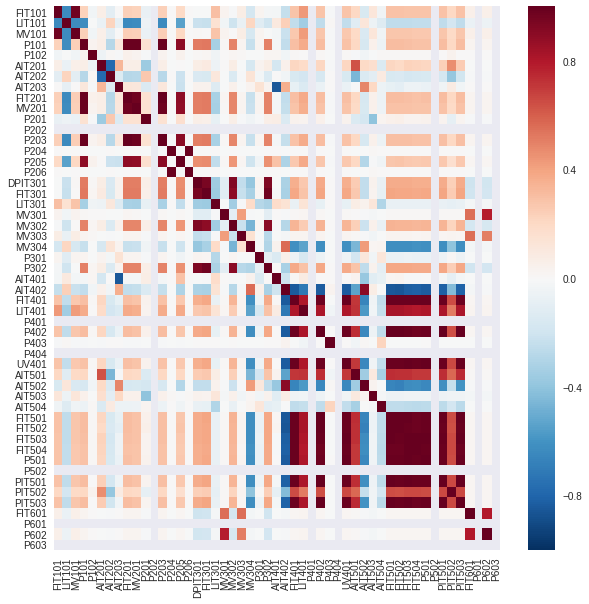

In [470]:
# visualization of the correlation matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(corr)#, xticklabels=corr.columns,yticklabels=corr.columns)

The above plot suggests that there are some correlations, especially between signals of the same type.

In addition, FIT (flow), PIT (pressure) and PS (pressure switch) signals seem to correlate significantly. 

The rest of the data do not correlate so much with each other.

# *Separate the data into training and testing. Use the data until the day of the first anomaly as training.*

To do that, we implemented the function "pre-process". This function does the following:
* Finds the index of the first record which is labeled as attack
* Creates two dataframes: one with all the records until the first attack (training set) and another one with the rest of them.
* Removes columns which have less than three different values (they do not offer useful information neither on PCA or in ARMA method).
* Returns the two dataframes

In [471]:
def pre_process(attack_df, normal_df):
    print("Pre-processing and creating training and testing sets.")
    print("* Splitting in training and testing set")
    # Create training and testing data frames
    first_attack_row_index = -1
    for index, row in attack_df.iterrows():
        if row['Normal/Attack'] == 1:
            first_attack_row_index = index
            break

    df_before_attack = attack_df.iloc[:first_attack_row_index, :]
    training_set = pd.concat([normal_df, df_before_attack])
    testing_set = attack_df.iloc[first_attack_row_index:, :]

    print("* Removing actuators")
    columns = list(training_set)
    # For all columns except the label
    # remove actuators: values '1', '2'
    for column in columns[:-1]:
        if len(training_set[column].unique()) < 3:
            del training_set[column]
            del testing_set[column]

    print("\t\tDone.")
    return training_set, testing_set

In order to check our spliting method we print the size of the two sets and the first and last record of them. As it can be seen from the results of the code below 

In [472]:
training_set, testing_set = pre_process(attack_data, normal_data)
print ("The size of the training set is: %i" %len(training_set))
print ("The size of the testing set is: %i \n" %len(testing_set))
       
print ("First record of the training set: %s " % training_set["Timestamp"].iloc[0])
print ("Last record of the training set: %s \n" % training_set["Timestamp"].iloc[-1])
       
print ("First record of the testing set: %s " % testing_set["Timestamp"].iloc[0])
print ("Last record of the testing set: %s " % testing_set["Timestamp"].iloc[-1])

Pre-processing and creating training and testing sets.
* Splitting in training and testing set
* Removing actuators
		Done.
The size of the training set is: 498554
The size of the testing set is: 448165 

First record of the training set:  22/12/2015 4:00:00 PM 
Last record of the training set:  28/12/2015 10:29:13 AM 

First record of the testing set:  28/12/2015 10:29:14 AM 
Last record of the testing set:  2/1/2016 2:59:59 PM 


# PCA Task
The following functions are used to perform pca based anomaly detection. 

In [473]:
def normalize(np_dataset):
    return (np_dataset - np_dataset.mean(axis=0))/np_dataset.std(axis=0)

def normalize_and_sample_testing_set(testing_set, sampling_rate):
    # Save the labels
    testing_labels = np.array(testing_set["Normal/Attack"].tolist())
    # Remove the "Normal/Attack", "Timestamp" columns
    testing_set = testing_set.drop(["Normal/Attack", "Timestamp"], axis=1)
    
    # Sample from the testing set according to the sampling rate
    _, sampled_testing_set, _, sampled_testing_labels = train_test_split(testing_set.values, testing_labels, test_size=sampling_rate)
    
    # Return the normalized samples and the their labels
    return normalize(sampled_testing_set), sampled_testing_labels

def get_sampled_and_normalized_dataset_pca(training_set, testing_set, seconds, testing_sampling_rate ):
    # Remove the "Normal/Attack", "Timestamp" columns from the training set
    training_set = training_set.drop(["Normal/Attack", "Timestamp"], axis=1)
    
    # Tranform the training set by replacing records of every 120 seconds with one record 
    # that takes the mean of all these records, because training on the whole data takes to much time
    training_set_sampled = training_set.groupby(np.arange(len(training_set)) // seconds).mean()
    training_set_sampled = normalize(training_set_sampled.values)
    
    # Sample from the testing data, testing on the whole data takes too much time
    testing_set_sampled, testing_labels = normalize_and_sample_testing_set(testing_set, testing_sampling_rate)
    return training_set_sampled, testing_set_sampled, testing_labels

In [474]:
def get_pca(training_data):
    # Get the principal components
    print("Applying PCA!!")
    ipca = IncrementalPCA()
    ipca.fit(training_data)
    print("\t\tDone.")
    return ipca

In [475]:
###
## This function gets the index of the eigen vector, which together with the eigenvectors with bigger eigenvalue,
## captures the accumulative variability given by the threshold
###
def get_threshold_index(variance_per_eigenvector, threshold):
    accumulative_variance = list(map(lambda index : sum(variance_per_eigenvector[:index + 1]), range(len(variance_per_eigenvector))))
    index_threshold = -1
    for index in range(len(accumulative_variance)):
        if accumulative_variance[index]> threshold:
            index_threshold = index
            break
    return index_threshold
###
## This function returns the high and low subspace of the training data
###
def get_high_low_projection_matrices(training_data):
    threshold_high_variability = 0.99

    # Get the all the eigen vectors of the feature vector
    pca = get_pca(training_data)

    # Get the index of the eigen vector, which together with the eigenvectors with bigger eigenvalue
    # captures the accumulative variability given by the threshold
    index_threshold = get_threshold_index(pca.explained_variance_ratio_, threshold_high_variability)

    # Get the subspaces with high and low variance
    principle_components = pca.components_[:index_threshold + 1, :]
    high_variance_projection_matrix = np.dot(np.transpose(principle_components), principle_components)
    low_variance_projection_matrix = (np.identity(len(high_variance_projection_matrix)) - high_variance_projection_matrix)
    return high_variance_projection_matrix, low_variance_projection_matrix

In [476]:
def get_residuals(training_data, testing_data):
    # Get the high variance and low variance space
    high_variance_projection_matrix, low_variance_projection_matrix = get_high_low_projection_matrices(training_data)

    # This lambda function returns the squared prediction error of a record
    squared_prediction_error = lambda v: np.square(np.linalg.norm(np.dot(low_variance_projection_matrix, np.transpose(v))))
    # This lambda function applies the squared_prediction_error on each of the record of a given container
    compute_residuals = lambda container: map(lambda index: squared_prediction_error(container[index]), range(len(container)))

    return list(compute_residuals(training_data)), list(compute_residuals(testing_data))

In [477]:
# Tranform the training set by replacing records of every 120 seconds with one record that takes the mean of all these records
# Sample the testing set by the given sampling rate
# You may change the sampling rate to test the prediction model with a bigger test set
interval_sampling_training = 120
sampling_testing_rate = 0.005
sampled_training_set_pca, sampled_testing_set_pca, testing_labels_pca = \
        get_sampled_and_normalized_dataset_pca(training_set, testing_set, interval_sampling_training,sampling_testing_rate)

# Get pca eigenvectors using the training_set
# Compute the PCA residuals on the training and testing set
training_residuals, testing_residuals = get_residuals(sampled_training_set_pca, sampled_testing_set_pca)

Applying PCA!!
		Done.


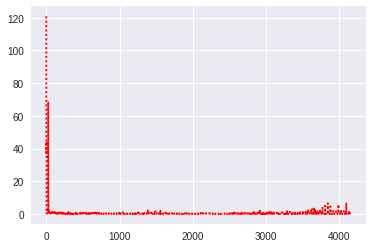

In [478]:
plt.plot(range(len(training_residuals)), training_residuals, "r:")
plt.show()

It is clear from the residuals on the training set, that there are a lot of anomolies at the beginning of the time series. Probably the start of the system caused non-typical values of the sensors. Let's zoom in at the beggining.

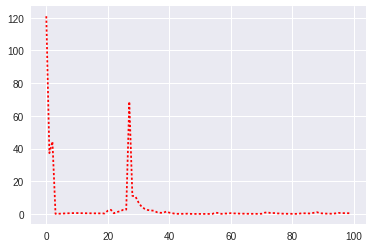

In [479]:
plt.plot(range(100), training_residuals[0:100], "r:")
plt.show()

Let's remove the first 35 anomaly records, such that these record do not effect the behaviour of the normal model.

In [480]:
# Remove the first 35 samples of the sampled trainingset
sampled_training_set_pca = sampled_training_set_pca[35:]

# Get pca eigenvector using the new training dataset 
# Compute the PCA residuals on the training and testing set
training_residuals, testing_residuals = get_residuals(sampled_training_set_pca, sampled_testing_set_pca)

Applying PCA!!
		Done.


## Distribution residuals trainingset
Let's view the distribution of the residuals of the trainingset to get a threshold.

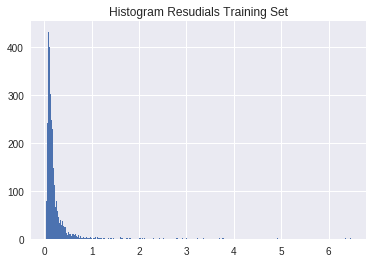

In [481]:
plt.hist(training_residuals, bins='auto')
plt.title("Histogram Resudials Training Set")
plt.show()

It is clear from the histogram that a lot of the residuals of the training set are close to 0. Let's take 7 as the threshold, i.e. every residual greater than one will be classified as an anomaly.

## Evaluation

In [482]:
##
# This function predicts all the residuals with values greater than the threshold as an anomaly (1) 
##
def predict(residuals, threshold):
    return list(map(lambda value: 0 if value<threshold else 1, residuals))

In [483]:
def get_evaluation_metrics_pca(testing_residuals, real_labels):
    threshold = 7
    prediction_pca = predict(testing_residuals, threshold)
    print("Confusion matrix (rows: prediction; columns: reference):")
    print(np.transpose(np.array(confusion_matrix(real_labels, prediction_pca))))
    print("Precision:")
    print(average_precision_score(real_labels, prediction_pca))
    print("Recall:")
    print(recall_score(real_labels, prediction_pca))
    print("F1 score:")
    print(f1_score(real_labels, prediction_pca))
    
get_evaluation_metrics_pca(testing_residuals,testing_labels_pca )

Confusion matrix (rows: prediction; columns: reference):
[[1860   74]
 [ 101  206]]
Precision:
0.719872515241
Recall:
0.735714285714
F1 score:
0.701873935264


In the perspective of precision, recall and F1 score the pca model performs very well. 

# ARMA Task

For the ARMA task we used both Python and R. Python was used for the pre-processing of the data while R was used 
for the training of the ARMA model and the evaluation of it.


# Pre-processing for ARMA 

Before we implement ARMA we had to decide how we would use our data. Our training set had too many records which could not be used for ARMA. ARMA is not able to take into consideration a lot of past values therefore we had to consider a way to use less records. On the other hand, for PCA the large amount of records was no problem.

For ARMA, our initial idea was to just use less training data. However, if we had used a random subset of our training set there would not be any patterns in our data. To include some of the patterns we would have to use a large amount of records from the training set which would again resulted to bad predictions using ARMA (we actually tried that).

Another idea we had was to use every ith record. However, this is not a good idea either due to the fact that in that way ARMA would process this data as sequential while in our test set the data would truly be sequential.

The best solution we came up with is the following: we implemented a function (*get_sampled_dataset_arma*) which takes as input a number of seconds and it computes for each signal the mean value of the signal for all those seconds. For example, if we call *train_sampled, test_sampled = get_sample_dataset_arma(120)* train_sampled and test_sampled will end up having records which correspond to every two minutes of the actual records. 

An interesting question now is: what to do with the labels? We experimented with two approaches. On the first approach we counted the *Normal* and *Attack* labels over the time interval we had selected and we labeled our new mean record according to the higher number of labels. Nevertheless, this logic did not seem so reasonable. We realized that it would make more sense to consider a time interval as *Attack* even if there is one attack inside this interval.

In that way, by changing the time interval we are able to identify if an attack exists in this specific time interval. For example, by using 2 minutes we can identify on which two minutes attacks occured.

Thus, imagine that we have trained our model and now we have a test set to evaluate it. Instead of using the test set per second we use it per minute (or another time interval) by taking the mean of the values of each signal. In addition we consider the true labels as if there is an attack in those time intervals.

In that way ARMA is able to identify some patterns and make predictions. By using data per second ARMA models would just return a static value.

Below, we present the pre-processing function for ARMA.

In [484]:
def get_sampled_dataset_arma(seconds, attack_data, normal_data):
    
    # Get the training and testing pre-processed sets
    training_set, testing_set = pre_process(attack_data, normal_data)

    if seconds == 1:
        training_set_sampled = training_set
        testing_set_sampled = testing_set
    else:
        training_set_sampled = training_set.groupby(np.arange(len(training_set)) // seconds).mean()
        training_set_sampled.loc[training_set_sampled["Normal/Attack"] > 0, 'Normal/Attack'] = 1

        testing_set_sampled = testing_set.groupby(np.arange(len(testing_set)) // seconds).mean()
        testing_set_sampled.loc[testing_set_sampled["Normal/Attack"] > 0, 'Normal/Attack'] = 1
    
    return training_set_sampled, testing_set_sampled

In [485]:
# function to write the datasets to file so that it can be then used by R
def write_to_file_arma(training_set, testing_set):
    training_path = os.path.join('.', 'data', 'training_arma.csv')
    testing_path = os.path.join('.', 'data', 'testing_arma.csv')
    print("Writing training and testing set to file to avoid recomputation.")
    training_set.to_csv(path_or_buf=training_path, index=False)
    testing_set.to_csv(path_or_buf=testing_path, index=False)
    print("\t\tDone.")

In [486]:
# We create the training and testing set for ARM
number_of_seconds = 900 # change this variable if you want to play with different time intervals
training_set_arma, testing_set_arma = get_sampled_dataset_arma(number_of_seconds, attack_data, normal_data)
write_to_file_arma(training_set_arma, testing_set_arma)

Pre-processing and creating training and testing sets.
* Splitting in training and testing set
* Removing actuators
		Done.
Writing training and testing set to file to avoid recomputation.
		Done.


Now that we have our training and testing set we are going to use R for the rest.

In [487]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Reading the files
Next, we install the needed R packages, set the Path and read the training and testing
csv files.

The path should be in a folder which contains the folder data!

R will use:
* /data/training_arma.csv 
* /data/testing_arma.csv

In [488]:
%%R
# install.packages('tseries')
library(tseries)
# install.packages('TTR')
library(TTR)
# install.packages('forecast')
library(forecast)
# install.packages('caret')
library(caret)

setwd("/home/bill/github_repos/cda/Cyber-Data-Analytics/Assignment_2");

# Read the dataset (pre-processed datasets)
train_data <- read.csv('./data/training_arma.csv',header = TRUE)
test_data <- read.csv('./data/testing_arma.csv',header = TRUE)

Then, we study the first three sensors. Those are:

In [489]:
%%R
three_signals = names(train_data[1:3])
print(three_signals)

[1] "FIT101" "LIT101" "MV101" 


# First three sensors
Now, we are going to study those signals. The function below takes a signal as input and:
* Converts the data to time series object
* Plots the training and test sets.

* Creates an ARMA model by using auto.arima. auto.arima selects the parameters depending on the lowest AIC value of different models. In addition, we have forced the d value to be zero so that the model remains an ARMA model (and not ARIMA).

* Makes predictions for all the objects in the test set.

* Plots the predictions.

* Defines the threshold (the explanation of this selection is in the comments).

* Compares the difference between the predicted values and the actual values and if this difference is larger than the threshold it labels the specified object as anomaly. Otherwise, it labels it as normal.

* Computes the confusion matrix.

In [490]:
%%R
build_arma_and_plot <- function(signal, flag_for_plots){
    # convert data into time series
    train_ts <- ts(as.numeric(unlist(train_data[signal])), start = 1)
    test_ts <- ts(as.numeric(unlist(test_data[signal])), start =1)
    
    if (flag_for_plots==1){
        # plot the training and test sets
        plot.ts(train_ts, main = paste("Training Set (", signal,")"))
        plot.ts(test_ts, main = paste("Testing Set (", signal,")"))
    }
    # Automated forecasting using an ARIMA model
    # picks the model with the best AIC value
    number_of_predictions = length(test_ts) #predict all values for testing set
    fit <- auto.arima(train_ts, d=0)
    
    timeseriesforecasts <- forecast.Arima(fit, h=number_of_predictions)

    if (flag_for_plots==1){
    # plot the prediction
    plot.forecast(timeseriesforecasts)
    }
    # Results
    # mean values of the prediction
    mean_forecasts <- timeseriesforecasts$mean

    # Definition of the threshold. If the difference between the predicted values and the
    # actual values is larger than the threshold, we consider the value as anomaly.
    # The threshold is based on the std of the training set 
    # (as they did in "Modeling Heterogeneous Time Series Dynamics to Profile Big Sensor Data in
    # Complex Physical Systems). After some experimentation we decided to take 2 times the standard 
    # deviation. In that way, we got the best results.

    # 1.9
    thr <- 2 * sd(unlist(train_data[signal]))

    # Computation of the Labels
    predictions <- ((abs(mean_forecasts - unlist(test_data[signal])))>thr)*1
    true_labels <- test_data$Normal.Attack
    df <- (confusionMatrix(predictions, true_labels, positive="1"))
    if (flag_for_plots==1){
        print(df) # print confusion matrix
        print(df$byClass) # print other metrics
        }
    return(data.frame(predictions))
    
}


 ## *Use	AIC	or	autocorrelation	plots	for	identifying	the	order	and	parameters	of	the	ARMA	models*	

As decscribed above we used the AIC to identify the order and parameters of the ARMA models that we use. This was done automatically by auto.arima which picks the model with the lowest AIC value.

## *For	the	first	three	sensors,	study	the	anomalies	detected.	What	kind	of	patterns	do	the	ARMA	models	detect?	* ##

It's time to study the first three signals. 

Let's now call this function for the first signal: LIT101

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 410  46
         1   4  38
                                          
               Accuracy : 0.8996          
                 95% CI : (0.8698, 0.9246)
    No Information Rate : 0.8313          
    P-Value [Acc > NIR] : 1.037e-05       
                                          
                  Kappa : 0.5529          
 Mcnemar's Test P-Value : 6.700e-09       
                                          
            Sensitivity : 0.45238         
            Specificity : 0.99034         
         Pos Pred Value : 0.90476         
         Neg Pred Value : 0.89912         
             Prevalence : 0.16867         
         Detection Rate : 0.07631         
   Detection Prevalence : 0.08434         
      Balanced Accuracy : 0.72136         
                                          
       'Positive' Class : 1               
                                          
         Sensitivity          

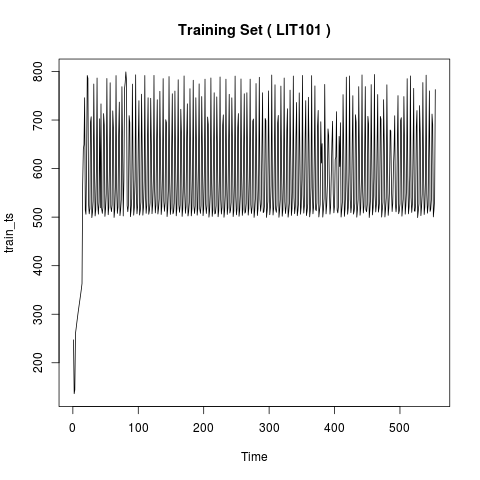

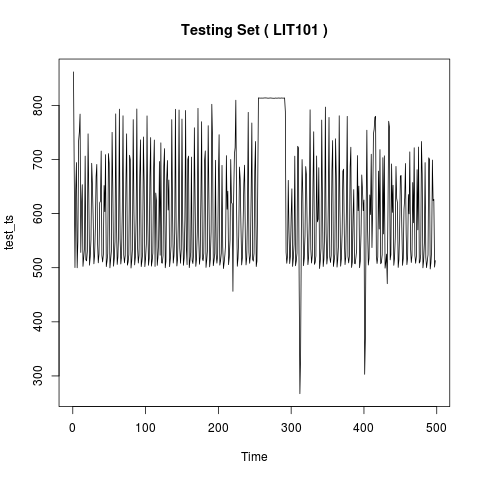

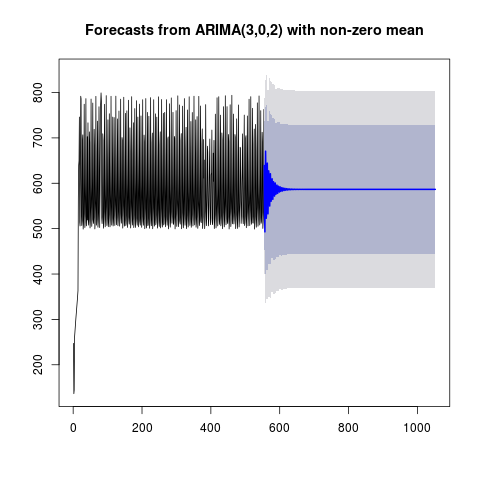

In [491]:
%%R
predictions <- build_arma_and_plot('LIT101',1)

From the results above we can see that we have 

accuracy = 0.8996

4 False Positives

38 False Negatives

410 True Negatives (normal)

46 True Positives (anomalies)

We can also see other metrics. From the plots we could observe that while in the beginning the ARMA model predicts the pattern of the signal, after a while it converges to a value (which is close to the overall mean value of the signal).

We will run the same function for the other two signals. The evaluation of the model could be seen from the results of the code.

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 389  43
         1  25  41
                                          
               Accuracy : 0.8635          
                 95% CI : (0.8301, 0.8924)
    No Information Rate : 0.8313          
    P-Value [Acc > NIR] : 0.02933         
                                          
                  Kappa : 0.4676          
 Mcnemar's Test P-Value : 0.03925         
                                          
            Sensitivity : 0.48810         
            Specificity : 0.93961         
         Pos Pred Value : 0.62121         
         Neg Pred Value : 0.90046         
             Prevalence : 0.16867         
         Detection Rate : 0.08233         
   Detection Prevalence : 0.13253         
      Balanced Accuracy : 0.71385         
                                          
       'Positive' Class : 1               
                                          
         Sensitivity          

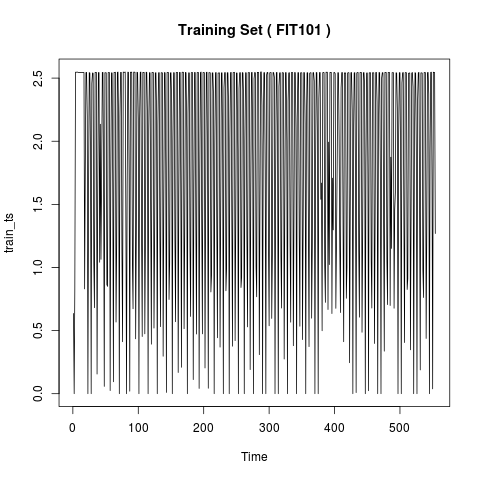

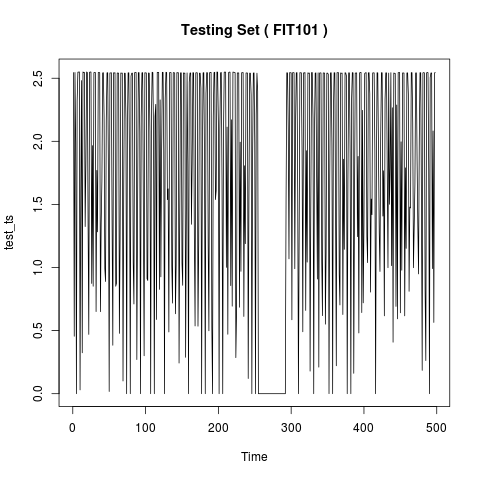

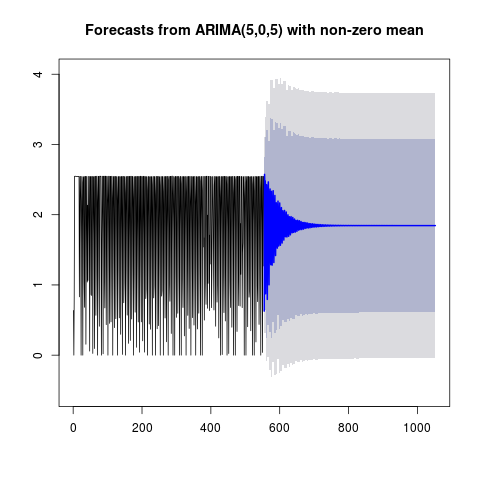

In [492]:
%%R
predictions <- build_arma_and_plot('FIT101',1)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 394  43
         1  20  41
                                          
               Accuracy : 0.8735          
                 95% CI : (0.8411, 0.9014)
    No Information Rate : 0.8313          
    P-Value [Acc > NIR] : 0.005722        
                                          
                  Kappa : 0.4937          
 Mcnemar's Test P-Value : 0.005576        
                                          
            Sensitivity : 0.48810         
            Specificity : 0.95169         
         Pos Pred Value : 0.67213         
         Neg Pred Value : 0.90160         
             Prevalence : 0.16867         
         Detection Rate : 0.08233         
   Detection Prevalence : 0.12249         
      Balanced Accuracy : 0.71989         
                                          
       'Positive' Class : 1               
                                          
         Sensitivity          

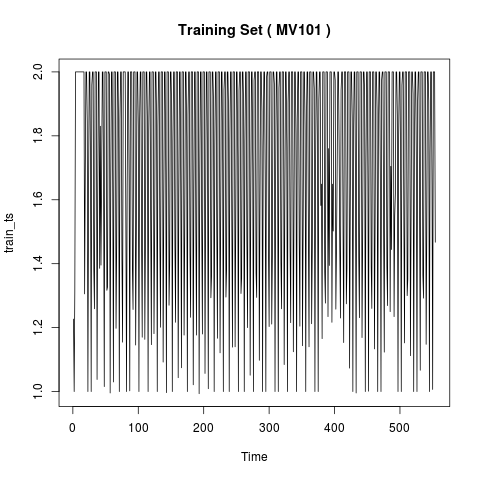

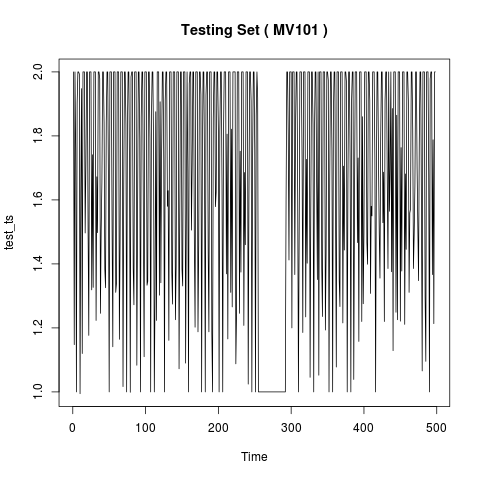

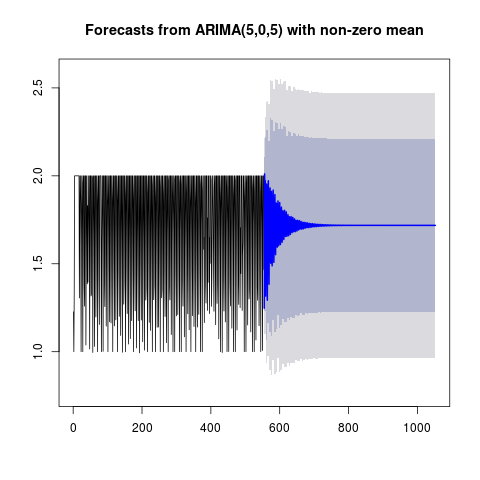

In [493]:
%%R
predictions <- build_arma_and_plot("MV101", 1)

For all three signals the results are similar. In all cases, the ARMA model converges to the mean value of the signal. However, the pattern of the signals are visible from the plots and the results of the model are not bad. In the time interval of the 15 minutes they predict more than half of the anomalies while keeping a relatively small number of false positives.

## * Think	of	a	way	(study	the	papers)	to	combine	the	predictions	of	all	the	individual	models	into	a	single	anomaly	detection	method.	Implement	it. * ##

To combine the predictions of all the inividual models we decided to use majority voting. Thus, we firstly computed for each signal the labels as described above and then we label each record according what most of the models decided. 

We realized that we could get even better results if we labeled a record as normal when more than half of the models had labeled it as normal. Otherwise, we label it as an attack. With this logic we got the following results.


In [494]:
%%R
# This might take a while to run

# initialize dataframe with results (number of rows same as test set)
results <- data.frame(init=numeric(nrow(test_data)))

for (signal in names(train_data)[1:length(train_data)-1]){
    results[signal] <- build_arma_and_plot(signal,0)
}

# delete initialization column
results$init <- NULL

# create majority labels
majority_labels <- ((rowSums(results==1) - rowSums(results==0))>-16)*1

df <- (confusionMatrix(majority_labels, true_labels, positive="1"))
print(df) # print confusion matrix
print(df$byClass) # print other metrics


Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 412  43
         1   2  41
                                         
               Accuracy : 0.9096         
                 95% CI : (0.881, 0.9333)
    No Information Rate : 0.8313         
    P-Value [Acc > NIR] : 3.657e-07      
                                         
                  Kappa : 0.6            
 Mcnemar's Test P-Value : 2.479e-09      
                                         
            Sensitivity : 0.48810        
            Specificity : 0.99517        
         Pos Pred Value : 0.95349        
         Neg Pred Value : 0.90549        
             Prevalence : 0.16867        
         Detection Rate : 0.08233        
   Detection Prevalence : 0.08635        
      Balanced Accuracy : 0.74163        
                                         
       'Positive' Class : 1              
                                         
         Sensitivity          Specificity       Po

The above results are promising. We more specifically focus on the False Positives (2) and the True Negatives (41). The reason we focus on those metrics is that this model tried to detect as many anomalies as possible (True Negatives) without alarming when there is no attack happening. 

In addition, it is interesting how the combination of all the signals (except of the actuaators) provides so much better results. Even if the predictions are converging the final result is reasonable.

Of course by tuning the threshold, the majority rule and the seconds on which we are trying to detect the anomaly we get different results. In fact, we believe that the arma anomaly detection model which we built is usefull because the user has the option to either select a large time interval and predict the anomaly with higher probability or choose a smaller time interval but predict less anomalies.

# Comparison Task

To compare the two methods we must have the same test set. Due to the fact that the PCA method is more flexible we decided to use ARMA's test set in both cases. 

Let's use the pca model on the ARMA's test set.

In [495]:
# Get pca eigenvector using the training_set
# Compute the PCA residuals on the training and testing set()
normalized_arma_testing_set = normalize(testing_set_arma.values[:,:-1])
training_residuals, testing_residuals_combo = get_residuals(sampled_training_set_pca, normalized_arma_testing_set)

Applying PCA!!
		Done.


## Similarity of the two models

To check the similarity of the two models we chose the *overlap-based false and true positives* method. Thus, we consider the ARMA's labels as the true ones and the PCA's labels as the predicted ones. The result could be seen by runnning the code below.

The similarity information is important for us to understand if the combination of the models could lead to better results or if they are almost the same models. In addition, if they have major differences it could mean that they detect different kind of anomalies and this could also be used.

In [496]:
%%R -i prediction_pca_combo
confusionMatrix(prediction_pca_combo,majority_labels, positive="1")

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 435   4
         1  20  39
                                          
               Accuracy : 0.9518          
                 95% CI : (0.9291, 0.9689)
    No Information Rate : 0.9137          
    P-Value [Acc > NIR] : 0.0007732       
                                          
                  Kappa : 0.7386          
 Mcnemar's Test P-Value : 0.0021996       
                                          
            Sensitivity : 0.90698         
            Specificity : 0.95604         
         Pos Pred Value : 0.66102         
         Neg Pred Value : 0.99089         
             Prevalence : 0.08635         
         Detection Rate : 0.07831         
   Detection Prevalence : 0.11847         
      Balanced Accuracy : 0.93151         
                                          
       'Positive' Class : 1               
                                          


From the results above, we can see that the accuracy (basically how similar our models are) is 95%.The two models gave the same label to 474 records and a different label to only 24 records. 

The models seem to be significantly similar.

# Comparison of evaluation metrics

Similarity is not the only metric that matters when comparing two different models. 

Obviously, it is very important to compare the performance of each model.

For that reason, we compute various evaluation metrics for both models on the same testing set.


In [497]:
%%R
# ARMA RESULTS
print(df) # print confusion matrix
print(df$byClass) # print other metrics

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 412  43
         1   2  41
                                         
               Accuracy : 0.9096         
                 95% CI : (0.881, 0.9333)
    No Information Rate : 0.8313         
    P-Value [Acc > NIR] : 3.657e-07      
                                         
                  Kappa : 0.6            
 Mcnemar's Test P-Value : 2.479e-09      
                                         
            Sensitivity : 0.48810        
            Specificity : 0.99517        
         Pos Pred Value : 0.95349        
         Neg Pred Value : 0.90549        
             Prevalence : 0.16867        
         Detection Rate : 0.08233        
   Detection Prevalence : 0.08635        
      Balanced Accuracy : 0.74163        
                                         
       'Positive' Class : 1              
                                         
         Sensitivity          Specificity       Po

In [498]:
# PCA RESULTS
get_evaluation_metrics_pca(testing_residuals_combo,testing_set_arma['Normal/Attack'].tolist()  )

Confusion matrix (rows: prediction; columns: reference):
[[414  40]
 [  0  44]]
Precision:
0.802065404475
Recall:
0.52380952381
F1 score:
0.6875


The results above suggest that also their performance is extremely similar. The values of all the metrics are very close for the two models. However, we adapt the problem according to the limitations of ARMA (using minutes instead of seconds). In real time systems, PCA will be able to predict anomalies in scale of seconds while ARMA might take minutes.Thus, we believe that the better choice for anomaly detection would be PCA or a combination of both. ARMA's performance is reasonably good only in scale of minutes. 

As it is written in the exercise *Keep in mind that in practice an analyst has to take action on every positive detected, but will not study every detected data point*, it is important to keep the number of False positives low. In this context PCA also performs better because it has sightly less False Positives and False Negative records. 

